# Football Prediction (English Premier League)

### We calculate, if a team playing home plays another team playing away, who has a larger probability of winning and by what goals.

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
# import xgboost as xgb
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
from IPython.display import display
from os import listdir
%matplotlib inline

### Data used for the calculations is collected from [here](https://www.football-data.co.uk/englandm.php). Please refer this [link](http://football-data.co.uk/notes.txt) for ancronyms of datapoints.

#### Data is from EPL15-19

In [2]:
'''
From all the datapoints we have only choosen the 
ones thatwere actually useful for our calculations.
'''


filepaths = ['./Pre/'+f for f in listdir("./Pre") if f.endswith('.csv')]
premier = pd.concat(map(pd.read_csv, filepaths), ignore_index=True,sort=False)

premier = premier.iloc[:,1:23].dropna().drop(['Referee'], axis = 1).drop_duplicates(inplace=False).reset_index(drop=True)
cols = ['Date', 'HomeTeam', 'AwayTeam', 'HTHG', 'HTAG', 'FTHG', 'FTAG',
       'HST', 'AST', 'HC', 'AC', 'HY', 'AY','HR', 'AR','HTR','FTR']
premier = premier[cols]
premier

Date        HomeTeam          AwayTeam  HTHG  HTAG  FTHG  FTAG  \
0       13/08/16         Burnley           Swansea     0     0     0     1   
1       13/08/16  Crystal Palace         West Brom     0     0     0     1   
2       13/08/16         Everton         Tottenham     1     0     1     1   
3       13/08/16            Hull         Leicester     1     0     2     1   
4       13/08/16        Man City        Sunderland     1     0     2     1   
...          ...             ...               ...   ...   ...   ...   ...   
1515  26/07/2020       Leicester        Man United     0     0     0     2   
1516  26/07/2020        Man City           Norwich     2     0     5     0   
1517  26/07/2020       Newcastle         Liverpool     1     1     1     3   
1518  26/07/2020     Southampton  Sheffield United     0     1     3     1   
1519  26/07/2020        West Ham       Aston Villa     0     0     1     1   

      HST  AST  HC  AC  HY  AY  HR  AR HTR FTR  
0       3    9   7   4   3   2   0   0   D   A  
1       4    3   3   6   2   2   0   0   D   A  
2       6    4   5   6   0   0   0   0   H   D  
3       5    5   5   3   2   2   0   0   H   H  
4       4    3   9   6   1   2   0   0   H   H  
...   ...  ...  ..  ..  ..  ..  ..  ..  ..  ..  
1515    3    3   3   3   1   4   1   0   D   A  
1516   10    4   9   0   1   1   0   0   H   H  
1517    2    6   2   4   1   0   0   0   D   A  
1518    4    3   9   1   0   1   0   0   A   H  
1519    1    4   0   7   2   1   0   0   D   D  

[1520 rows x 17 columns]

## A common observation that win probability of a team play at home is higher than that of a team playing away


In [3]:
# Win Rate for home team
nOfMatches = premier.shape[0]
nOfFeatures = premier.shape[1] - 1
nOfHomeWins = len(premier[premier['FTR'] == 'H'])
nOfAwayWins = len(premier[premier['FTR'] == 'A'])
nOfDraw = len(premier[premier['FTR'] == 'D'])
homeWinRate = (float(nOfHomeWins/nOfMatches))*100
awayWinRate = (float(nOfAwayWins/nOfMatches))*100
drawRate = (float(nOfDraw/nOfMatches))*100

print("No. of matches: {}".format(nOfMatches))
print("No. of Features: {}".format(nOfFeatures))
print("No. of matches won by home: {}".format(nOfHomeWins))
print("No. of matches won by away: {}".format(nOfAwayWins))
print("No. of matches draw: {}".format(nOfDraw))
print("Home Win Rate: {:.1f}%".format(homeWinRate))
print("Away Win Rate: {:.1f}%".format(awayWinRate))
print("Draw Rate: {:.1f}%".format(drawRate))

No. of matches: 1520
No. of Features: 16
No. of matches won by home: 697
No. of matches won by away: 469
No. of matches draw: 354
Home Win Rate: 45.9%
Away Win Rate: 30.9%
Draw Rate: 23.3%


### From our data we would like to know the optimal number of goals that home team need to score in order to maximize it's chances of winning

Number of home teams scoring 2 goals and winning: 257


<AxesSubplot:xlabel='FTHG', ylabel='count'>

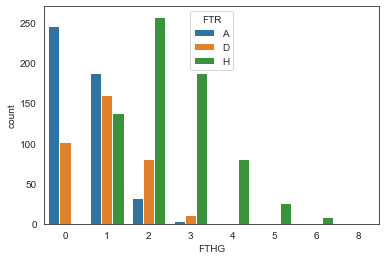

In [4]:
'''
Out of 1520 matches home teams scoring 2 goals have won the highest
number of matches (~250), followed by home teams scoring 3 goals. 
'''

temp = premier[(premier['FTHG']==2) & (premier['FTR']=='H')]['FTR'].count()
print("Number of home teams scoring 2 goals and winning: {}".format(temp))

sns.set_style('white')
sns.countplot(x='FTHG',data=premier, hue='FTR')

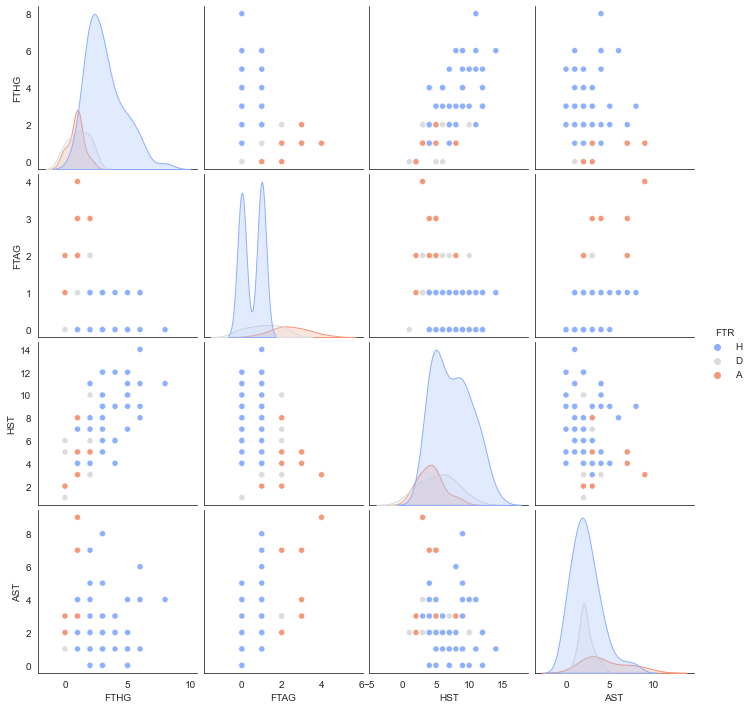

In [5]:
'''
We would like to know how are Full time home goals(FTHG),
away goals(FTAG), home shots on target(HST) & away shots on target(AST)
along with final result (FTR).
'''

temp = premier[premier['HomeTeam']=='Man City'][['FTHG', 'FTAG','HST', 'AST','FTR']]
sns.pairplot(temp,hue='FTR',palette='coolwarm')

Matches played home: 76
Matches played away: 76


'\nWhat we are seeing in bottom graph is that when Man City plays home(1st graph) or away (2nd graph),\nwhat is the final result of the match (i.e Home win, Away win, or Draw)\n'

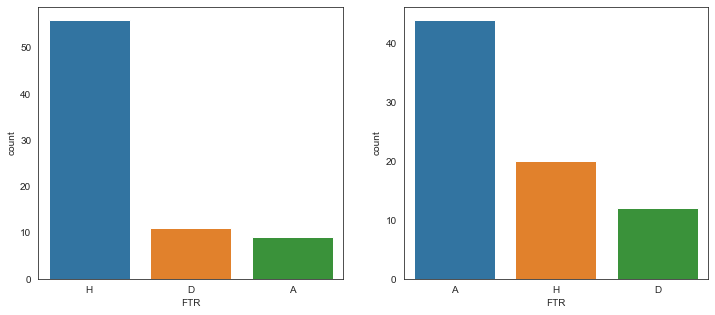

In [6]:
# Matches played home
print("Matches played home: {}".format(premier[premier['HomeTeam']=='Man City']['FTR'].count()))
# Matches played away
print("Matches played away: {}".format(premier[premier['AwayTeam']=='Man City']['FTR'].count()))

sns.set_style('white')
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x='FTR',data=premier[premier['HomeTeam']=='Man City'], ax=ax[0])
sns.countplot(x='FTR',data=premier[premier['AwayTeam']=='Man City'], ax=ax[1])

'''
What we are seeing in bottom graph is that when Man City plays home(1st graph) or away (2nd graph),
what is the final result of the match (i.e Home win, Away win, or Draw)
'''

In [7]:
'''
How often does a team playing home or away scores n no of goals
'''
hOa = ['HomeTeam','AwayTeam']
team = 'Man City'
noGoals = 2
n_goals = len(premier[(premier[hOa[0]]==team) & (premier['HTHG']==noGoals)])
n_matches = len(premier[premier[hOa[0]]==team])
print("Probability of scoring "+str(noGoals)+" goals: {:.2%}".format(n_goals/n_matches))

Probability of scoring 2 goals: 23.68%


### Till now we were looking towards statistical part of our data. Now we want to see the probabilistic side of the data.

### We build a poisson model for calculating the win probabilites of a team playing home vs a team playing away.

In [8]:
# Team's total appearance (Home + Away)
TotGame = premier['HomeTeam'].value_counts() + premier['AwayTeam'].value_counts()
# Team's Home appearances
HomeGame = premier['HomeTeam'].value_counts()
# Team's Away appearances
AwayGame = premier['AwayTeam'].value_counts()

team_info = pd.DataFrame([TotGame,HomeGame,AwayGame]).transpose().dropna()
team_info.reset_index(inplace=True)
headers = ['TeamName','TotGame','HomeGame','AwayGame']
team_info.columns = headers

team_info

TeamName  TotGame  HomeGame  AwayGame
0            Arsenal      152        76        76
1        Aston Villa       76        38        38
2        Bournemouth      152        76        76
3           Brighton       76        38        38
4            Burnley      114        57        57
5            Cardiff       38        19        19
6            Chelsea      152        76        76
7     Crystal Palace      152        76        76
8            Everton      152        76        76
9             Fulham       38        19        19
10      Huddersfield       38        19        19
11              Hull       38        19        19
12         Leicester      152        76        76
13         Liverpool      152        76        76
14          Man City      152        76        76
15        Man United      152        76        76
16     Middlesbrough       38        19        19
17         Newcastle      114        57        57
18           Norwich       76        38        38
19  Sheffield United       38        19        19
20       Southampton      152        76        76
21             Stoke       76        38        38
22        Sunderland       76        38        38
23           Swansea       76        38        38
24         Tottenham      152        76        76
25           Watford      152        76        76
26         West Brom       76        38        38
27          West Ham      152        76        76
28            Wolves       76        38        38

#### We want a function that sorts entire data based on teams. These creates our team statistics.

In [9]:
teams = ['HomeTeam','AwayTeam']
head_cols = ['HTHG', 'HTAG', 'FTHG', 'FTAG','HST', 'AST',
             'HC', 'AC', 'HY', 'AY','HR', 'AR']

'''
HT home goals scored    FT home goals scored    shots taken home          shots on target taken home            
HT away goals scored    FT away goals scored    shots taken away          shots on target taken away
HT home goals conceded  FT home goals conceded  shots taken against home  shots on target taken against home
HT away goals conceded  FT away goals conceded  shots taken against away  shots on target taken against away
'''

def count_stats(team_name):    
    stats = [0] * (len(head_cols) * 2)        
    
    for i in  range(len(stats)):
        j = i%2
        k = (int(i/2) + j)%2 + int(i/4)*2
        stats[i] = premier[premier[teams[j]]==team_name][head_cols[k]].sum()                 
    return stats

def count_wins(team_name):    
    wins = [0] * 6
    results = ['H','A','D']
    #home wins  #home lose  #home tie
    #away wins  #away lose  #away tie
    for i in range(len(wins)):
        j = i%2
        k = i%3
        wins[i] = len(premier[(premier[teams[j]]==team_name) & (premier['FTR'] == results[k])])
        
    wins[4],wins[2] = wins[2],wins[4]
    return wins

#### No we apply the above defined function on our dataset.

In [10]:
#HT = half time           #HSH = Home Shots taken playing Home
#FT = full time           #ASA = Away Shots taken playing Away
#GS = goals scored        #HSTA = Away Shots on target against Home
#GC = goals conceded      #ASTH = Home Shots on target taken against Away    and so on...
stats_types = ['HTHGS','HTAGS','HTAGC','HTHGC','FTHGS','FTAGS','FTAGC','FTHGC',
               'HSTH','ASTA','ASTH','HSTA','HCH', 'ACA','HCA', 'ACH',
               'HY', 'AY', 'AYH', 'HYA','HR', 'AR','HRA', 'ARH']

#W = wins  #L = Loss  #D = Draw/Tie
result_type = ['FTHW','FTAW','FTHL','FTAL','FTHD','FTAD']

list_of_stats = team_info.apply(lambda x: count_stats(x['TeamName']), axis=1)
team_info[stats_types] = pd.DataFrame.from_dict(dict(zip(list_of_stats.index, list_of_stats.values))).transpose()
team_info = team_info.drop(['AYH', 'HYA','ARH','HRA'], axis = 1)

list_of_wins = team_info.apply(lambda x: count_wins(x['TeamName']), axis=1)
team_info[result_type] = pd.DataFrame.from_dict(dict(zip(list_of_wins.index, list_of_wins.values))).transpose()

team_info

TeamName  TotGame  HomeGame  AwayGame  HTHGS  HTAGS  HTAGC  HTHGC  \
0            Arsenal      152        76        76     67     51     38     52   
1        Aston Villa       76        38        38     16     11     34     22   
2        Bournemouth      152        76        76     50     46     58     77   
3           Brighton       76        38        38     18     15     24     28   
4            Burnley      114        57        57     33     21     29     48   
5            Cardiff       38        19        19      8      3     18     12   
6            Chelsea      152        76        76     71     58     30     47   
7     Crystal Palace      152        76        76     31     29     37     47   
8            Everton      152        76        76     62     43     40     49   
9             Fulham       38        19        19      9      6     20     21   
10      Huddersfield       38        19        19      4      7     18     20   
11              Hull       38        19        19      8      3     12     16   
12         Leicester      152        76        76     49     41     32     61   
13         Liverpool      152        76        76     94     55     29     36   
14          Man City      152        76        76     90     75     28     40   
15        Man United      152        76        76     62     57     25     40   
16     Middlesbrough       38        19        19      9      6     11     16   
17         Newcastle      114        57        57     30     26     32     40   
18           Norwich       76        38        38     22      8     25     34   
19  Sheffield United       38        19        19     12      4      5     10   
20       Southampton      152        76        76     48     41     49     46   
21             Stoke       76        38        38     23     17     18     28   
22        Sunderland       76        38        38     15     14     26     31   
23           Swansea       76        38        38     24     16     20     25   
24         Tottenham      152        76        76     70     60     23     37   
25           Watford      152        76        76     30     38     50     63   
26         West Brom       76        38        38     25     14     21     24   
27          West Ham      152        76        76     50     44     50     50   
28            Wolves       76        38        38     18     13     20     28   

    FTHGS  FTAGS  ...   HY   AY  HR  AR  FTHW  FTAW  FTHL  FTAL  FTHD  FTAD  
0     148    123  ...  136  128   6   8    50    28    10    26    16    22  
1      36     32  ...   69   74   1   3     9     3    21    27     8     8  
2     110     86  ...  121  115   4   4    27    18    29    46    20    12  
3      39     35  ...   57   59   3   3    11     7    15    20    12    11  
4      74     53  ...   98  109   0   3    25    12    23    31     9    14  
5      21     13  ...   33   32   0   1     6     4    11    13     2     2  
6     156    120  ...  109  130   3   3    45    38    13    24    18    14  
7      77     94  ...  123  133   3   2    23    25    38    35    15    16  
8     131     88  ...  115  125   2  12    37    19    19    34    20    23  
9      22     12  ...   34   34   1   1     6     1    10    16     3     2  
10     10     12  ...   27   28   3   1     2     1    14    14     3     4  
11     28      9  ...   32   35   2   3     8     1     7    15     4     3  
12    125    109  ...   99  118   4   8    41    27    18    31    17    18  
13    185    130  ...   71  119   3   3    55    45     5    15    16    16  
14    198    150  ...  101  135   5   4    56    44     9    20    11    12  
15    126    108  ...  126  160   2   5    40    34     8    25    28    17  
16     17     10  ...   38   38   0   1     4     1     9    11     6     7  
17     76     48  ...   95   85   4   6    21    11    20    32    16    14  
18     45     20  ...   58   70   3   3    10     4    20    29     8     5  
19     24     15  ...

#### We sort the new data based on a team's home appearances & away appearances

In [11]:
new_stats_types = ['TeamName','TeamName','TotGame','TotGame','HomeGame','AwayGame',
                   'HTHGS','HTAGS','HTAGC','HTHGC','FTHGS','FTAGS','FTAGC','FTHGC',
                   'HSTH','ASTA','ASTH','HSTA','HCH', 'ACA','HCA', 'ACH',
                   'HY','AY','HR','AR','FTHW','FTAW','FTHL','FTAL','FTHD','FTAD']

# Even column names are Home stats
home_stats = new_stats_types[::2]
# Odd column names are Away stats
away_stats = new_stats_types[1::2]

In [12]:
HomeTeams = team_info[home_stats]
AwayTeams = team_info[away_stats]
AwayTeams

TeamName  TotGame  AwayGame  HTAGS  HTHGC  FTAGS  FTHGC  ASTA  \
0            Arsenal      152        76     51     52    123    112   315   
1        Aston Villa       76        38     11     22     32     78   119   
2        Bournemouth      152        76     46     77     86    151   271   
3           Brighton       76        38     15     28     35     59   129   
4            Burnley      114        57     21     48     53     98   158   
5            Cardiff       38        19      3     12     13     31    58   
6            Chelsea      152        76     58     47    120    104   345   
7     Crystal Palace      152        76     29     47     94    126   249   
8            Everton      152        76     43     49     88    113   314   
9             Fulham       38        19      6     21     12     45    63   
10      Huddersfield       38        19      7     20     12     45    61   
11              Hull       38        19      3     16      9     45    58   
12         Leicester      152        76     41     61    109    108   341   
13         Liverpool      152        76     55     36    130     81   406   
14          Man City      152        76     75     40    150     75   437   
15        Man United      152        76     57     40    108     91   357   
16     Middlesbrough       38        19      6     16     10     30    41   
17         Newcastle      114        57     26     40     48    101   177   
18           Norwich       76        38      8     34     20     75   116   
19  Sheffield United       38        19      4     10     15     24    45   
20       Southampton      152        76     41     46     92    106   339   
21             Stoke       76        38     17     28     36     63   124   
22        Sunderland       76        38     14     31     38     77   126   
23           Swansea       76        38     16     25     40     68   137   
24         Tottenham      152        76     60     37    131     90   380   
25           Watford      152        76     38     63     75    138   255   
26         West Brom       76        38     14     24     30     51    96   
27          West Ham      152        76     44     50     98    115   294   
28            Wolves       76        38     13     28     43     46   140   

    HSTA  ACA  ACH   AY  AR  FTAW  FTAL  FTAD  
0    363  375  425  128   8    28    26    22  
1    194  162  254   74   3     3    27     8  
2    391  372  448  115   4    18    46    12  
3    189  141  236   59   3     7    20    11  
4    335  206  422  109   3    12    31    14  
5    120   73  144   32   1     4    13     2  
6    289  407  311  130   3    38    24    14  
7    383  334  501  133   2    25    35    16  
8    346  361  435  125  12    19    34    23  
9    117   59  131   34   1     1    16     2  
10   102   77   98   28   1     1    14     4  
11   103  106  128   35   3     1    15     3  
12   332  399  464  118   8    27    31    18  
13   254  486  298  119   3    45    15    16  
14   234  516  253  135   4    44    20    12  
15   305  381  369  160   5    34    25    17  
16   105   48  122   38   1     1    11     7  
17   299  215  392   85   6    11    32    14  
18   201  151  252   70   3     4    29     5  
19    84   79  133   31   1     4     6     9  
20   320  406  443  131   4    26    32    18  
21   195  150  271   62   2    10    18    10  
22   249  135  271   74   3     6    25     7  
23   208  163  205   53   0     8    23     7  
24   310  419  400  156   4    33    22    21  
25   397  324  493  145   6    17    44    15  
26   176  159  224   85   1     7    16    15  
27   395  365  464  125   8    22    34    20  
28   139  191  193   68   3    13    13    12

In [13]:
HomeTeams.columns
AwayTeams.columns

Index(['TeamName', 'TotGame', 'AwayGame', 'HTAGS', 'HTHGC', 'FTAGS', 'FTHGC',
       'ASTA', 'HSTA', 'ACA', 'ACH', 'AY', 'AR', 'FTAW', 'FTAL', 'FTAD'],
      dtype='object')

#### Now we divide each of these stats by total no. of home/away games played in order to find stats per match.

In [14]:
def sumStats(data):
    return data.sum()

def avgStatsHome(data):
    return data.sum()/HomeStats['HomeGame']

def avgStatsAway(data):
    return data.sum()/AwayStats['AwayGame']

In [15]:
HomeStats = HomeTeams[['HomeGame', 'HTHGS', 'HTAGC', 'FTHGS', 'FTAGC',
       'HSTH', 'ASTH', 'HCH', 'HCA', 'HY', 'HR', 'FTHW', 'FTHL', 'FTHD']].apply(sumStats)
AwayStats = AwayTeams[['AwayGame', 'HTAGS', 'HTHGC', 'FTAGS', 'FTHGC',
       'ASTA', 'HSTA', 'ACA', 'ACH', 'AY', 'AR', 'FTAW', 'FTAL', 'FTAD']].apply(sumStats)

HomeStatsPerMatch = HomeTeams[['HomeGame', 'HTHGS', 'HTAGC', 'FTHGS', 'FTAGC',
       'HSTH', 'ASTH', 'HCH', 'HCA', 'HY', 'HR', 'FTHW', 'FTHL', 'FTHD']].apply(avgStatsHome)
AwayStatsPerMatch = AwayTeams[['AwayGame', 'HTAGS', 'HTHGC', 'FTAGS', 'FTHGC',
       'ASTA', 'HSTA', 'ACA', 'ACH', 'AY', 'AR', 'FTAW', 'FTAL', 'FTAD']].apply(avgStatsAway)

In [16]:
'''
The same statics from above but just Goal scored info.
'''

TotalHomeGames = team_info['HomeGame'].sum()
TotalHomeGoals = team_info['FTHGS'].sum()
HomeGoalsPerMatch = TotalHomeGoals/TotalHomeGames

TotalAwayGames = team_info['AwayGame'].sum()
TotalAwayGoals = team_info['FTAGS'].sum()
AwayGoalsPerMatch = TotalAwayGoals/TotalAwayGames

print(TotalHomeGames,TotalHomeGoals)
print(TotalAwayGames,TotalAwayGoals)
print(HomeGoalsPerMatch,AwayGoalsPerMatch)

1520 2346
1520 1850
1.543421052631579 1.2171052631578947


In [17]:
'''
Data below displays overall stats (Home & Away)
and stats per match (Home and Away)
'''

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
display_side_by_side(pd.DataFrame(HomeStats),pd.DataFrame(AwayStats),pd.DataFrame(HomeStatsPerMatch),pd.DataFrame(AwayStatsPerMatch))
display(pd.DataFrame(AwayStats).loc['HTAGS'])

0 
 
 
 
 
 HomeGame 
 1520 
 
 
 HTHGS 
 1048 
 
 
 HTAGC 
 822 
 
 
 FTHGS 
 2346 
 
 
 FTAGC 
 1850 
 
 
 HSTH 
 7135 
 
 
 ASTH 
 5951 
 
 
 HCH 
 8780 
 
 
 HCA 
 7260 
 
 
 HY 
 2396 
 
 
 HR 
 86 
 
 
 FTHW 
 697 
 
 
 FTHL 
 469 
 
 
 FTHD 
 354 
 
 
 
 
 
 
 0 
 
 
 
 
 AwayGame 
 1520 
 
 
 HTAGS 
 822 
 
 
 HTHGC 
 1048 
 
 
 FTAGS 
 1850 
 
 
 FTHGC 
 2346 
 
 
 ASTA 
 5951 
 
 
 HSTA 
 7135 
 
 
 ACA 
 7260 
 
 
 ACH 
 8780 
 
 
 AY 
 2657 
 
 
 AR 
 106 
 
 
 FTAW 
 469 
 
 
 FTAL 
 697 
 
 
 FTAD 
 354 
 
 
 
 
 
 
 0 
 
 
 
 
 HomeGame 
 1.000000 
 
 
 HTHGS 
 0.689474 
 
 
 HTAGC 
 0.540789 
 
 
 FTHGS 
 1.543421 
 
 
 FTAGC 
 1.217105 
 
 
 HSTH 
 4.694079 
 
 
 ASTH 
 3.915132 
 
 
 HCH 
 5.776316 
 
 
 HCA 
 4.776316 
 
 
 HY 
 1.576316 
 
 
 HR 
 0.056579 
 
 
 FTHW 
 0.458553 
 
 
 FTHL 
 0.308553 
 
 
 FTHD 
 0.232895 
 
 
 
 
 
 
 0 
 
 
 
 
 AwayGame 
 1.000000 
 
 
 HTAGS 
 0.540789 
 
 
 HTHGC 
 0.689474 
 
 
 FTAGS 
 1.217105 
 
 
 FTHGC 
 1.543421 
 
 
 ASTA 
 3.915132 
 
 
 HSTA 
 4.694079 
 
 
 ACA 
 4.776316 
 
 
 ACH 
 5.776316 
 
 
 AY 
 1.748026 
 
 
 AR 
 0.069737 
 
 
 FTAW 
 0.308553 
 
 
 FTAL 
 0.458553 
 
 
 FTAD 
 0.232895

0    822
Name: HTAGS, dtype: int64

In [18]:
HomeStatsPerMatch.loc['HTHGS']

0.6894736842105263

### We want to calculate the strengths and weakness of each team. 
#### This means that when a team is playing Home what are its strength and what are its weakness. For now we have just considered the attack strength and calculated it based on goals scored and goals conceded.

In [19]:
def attackStr(data):
    strength = 1
    weakness = 1
    strn_list = ['HTHGS','FTHGS','HSTH','HCH','FTHW']
    wkn_list = ['HTAGC','FTAGC','ASTH','HCA','HY', 'HR', 'FTHL', 'FTHD']
#     for i in  range(len(HomeStatsPerMatch[1:])):
#         print(data[i]/HomeStatsPerMatch[i+1])
#     if(data.name in strengths):
#         print(data/HomeStatsPerMatch.loc[data.name])    
    for strn in strn_list:
        strength *= data[strn]/HomeStatsPerMatch.loc[strn]
    for wkns in wkn_list:
        weakness *= data[wkns]/HomeStatsPerMatch.loc[wkns]
    print(strength)
    
# HomeTeams_perMatch.iloc[:,3:].T.apply(attackStr)

In [20]:
Home_Stats = HomeTeams[['TeamName','TotGame','HomeGame']]
Home_Stats2 = HomeTeams.iloc[:,3:].div(HomeTeams.HomeGame, axis=0)
HomeTeams_perMatch = pd.merge(Home_Stats,Home_Stats2, left_index=True, right_index=True)
# Calculating Attack Strength for teams at Home
HomeTeams_perMatch['AttStr'] = HomeTeams_perMatch['FTHGS'].apply(lambda x: x/HomeGoalsPerMatch)
# Calculating Defence Strength for teams at Home
HomeTeams_perMatch['DefStr'] = HomeTeams_perMatch['FTAGC'].apply(lambda x: x/AwayGoalsPerMatch)
HomeTeams_perMatch

TeamName  TotGame  HomeGame     HTHGS     HTAGC     FTHGS  \
0            Arsenal      152        76  0.881579  0.500000  1.947368   
1        Aston Villa       76        38  0.421053  0.894737  0.947368   
2        Bournemouth      152        76  0.657895  0.763158  1.447368   
3           Brighton       76        38  0.473684  0.631579  1.026316   
4            Burnley      114        57  0.578947  0.508772  1.298246   
5            Cardiff       38        19  0.421053  0.947368  1.105263   
6            Chelsea      152        76  0.934211  0.394737  2.052632   
7     Crystal Palace      152        76  0.407895  0.486842  1.013158   
8            Everton      152        76  0.815789  0.526316  1.723684   
9             Fulham       38        19  0.473684  1.052632  1.157895   
10      Huddersfield       38        19  0.210526  0.947368  0.526316   
11              Hull       38        19  0.421053  0.631579  1.473684   
12         Leicester      152        76  0.644737  0.421053  1.644737   
13         Liverpool      152        76  1.236842  0.381579  2.434211   
14          Man City      152        76  1.184211  0.368421  2.605263   
15        Man United      152        76  0.815789  0.328947  1.657895   
16     Middlesbrough       38        19  0.473684  0.578947  0.894737   
17         Newcastle      114        57  0.526316  0.561404  1.333333   
18           Norwich       76        38  0.578947  0.657895  1.184211   
19  Sheffield United       38        19  0.631579  0.263158  1.263158   
20       Southampton      152        76  0.631579  0.644737  1.368421   
21             Stoke       76        38  0.605263  0.473684  1.210526   
22        Sunderland       76        38  0.394737  0.684211  1.026316   
23           Swansea       76        38  0.631579  0.526316  1.236842   
24         Tottenham      152        76  0.921053  0.302632  2.000000   
25           Watford      152        76  0.394737  0.657895  1.223684   
26         West Brom       76        38  0.657895  0.552632  1.236842   
27          West Ham      152        76  0.657895  0.657895  1.513158   
28            Wolves       76        38  0.473684  0.526316  1.447368   

       FTAGC      HSTH      ASTH       HCH       HCA        HY        HR  \
0   0.881579  5.473684  4.381579  6.868421  4.736842  1.789474  0.078947   
1   1.710526  3.736842  4.789474  5.394737  5.815789  1.815789  0.026316   
2   1.552632  4.171053  4.236842  5.592105  5.289474  1.592105  0.052632   
3   1.447368  3.184211  4.105263  5.078947  4.842105  1.500000  0.078947   
4   1.315789  3.701754  4.491228  4.456140  5.701754  1.719298  0.000000   
5   2.000000  3.578947  4.842105  5.000000  6.105263  1.736842  0.000000   
6   0.986842  5.960526  3.144737  6.750000  4.328947  1.434211  0.039474   
7   1.197368  4.039474  4.013158  6.171053  5.197368  1.618421  0.039474   
8   1.157895  5.052632  3.578947  6.197368  4.842105  1.513158  0.026316   
9   1.894737  4.526316  5.684211  5.368421  5.000000  1.789474  0.052632   
10  1.631579  3.000000  4.684211  4.473684  3.789474  1.421053  0.157895   
11  1.842105  3.631579  5.894737  3.842105  6.052632  1.684211  0.105263   
12  1.052632  4.723684  3.657895  5.618421  4.881579  1.302632  0.052632   
13  0.868421  6.447368  2.618421  7.039474  3.894737  0.934211  0.039474   
14  0.828947  6.750000  2.565789  7.973684  2.921053  1.328947  0.065789   
15  0.828947  5.750000  3.065789  6.157895  3.881579  1.657895  0.026316   
16  1.210526  3.105263  3.526316  4.894737  5.000000  2.000000  0.000000   
17  1.228070  4.350877  3.982456  4.824561  5.842105  1.666667  0.070175   
18  1.763158  3.710526  4.868421  5.236842  5.684211  1.526316  0.078947   
19  0.789474  3.684211  2.947368  7.000000  4.473684  1.578947  0.052632   
20  1.421053  4.631579  3.881579  5.539474  5.105263  1.421053  0.144737   
21  1.263158  3.763158  4.289474  5.026316  5.842105  1.552632  0.105263   
22  1.421053  3.631579  5.710526  4.868421  5.368421  1.684211  0.078947 

In [21]:
Away_Stats = AwayTeams[['TeamName','TotGame','AwayGame']]
Away_Stats2 = AwayTeams.iloc[:,3:].div(AwayTeams.AwayGame, axis=0)
AwayTeams_perMatch = pd.merge(Away_Stats,Away_Stats2, left_index=True, right_index=True)
# Calculating Attack Strength for teams at Away
AwayTeams_perMatch['AttStr'] = AwayTeams_perMatch['FTAGS'].apply(lambda x: x/AwayGoalsPerMatch)
# Calculating Defence Strength for teams at Away
AwayTeams_perMatch['DefStr'] = AwayTeams_perMatch['FTHGC'].apply(lambda x: x/HomeGoalsPerMatch)
AwayTeams_perMatch

TeamName  TotGame  AwayGame     HTAGS     HTHGC     FTAGS  \
0            Arsenal      152        76  0.671053  0.684211  1.618421   
1        Aston Villa       76        38  0.289474  0.578947  0.842105   
2        Bournemouth      152        76  0.605263  1.013158  1.131579   
3           Brighton       76        38  0.394737  0.736842  0.921053   
4            Burnley      114        57  0.368421  0.842105  0.929825   
5            Cardiff       38        19  0.157895  0.631579  0.684211   
6            Chelsea      152        76  0.763158  0.618421  1.578947   
7     Crystal Palace      152        76  0.381579  0.618421  1.236842   
8            Everton      152        76  0.565789  0.644737  1.157895   
9             Fulham       38        19  0.315789  1.105263  0.631579   
10      Huddersfield       38        19  0.368421  1.052632  0.631579   
11              Hull       38        19  0.157895  0.842105  0.473684   
12         Leicester      152        76  0.539474  0.802632  1.434211   
13         Liverpool      152        76  0.723684  0.473684  1.710526   
14          Man City      152        76  0.986842  0.526316  1.973684   
15        Man United      152        76  0.750000  0.526316  1.421053   
16     Middlesbrough       38        19  0.315789  0.842105  0.526316   
17         Newcastle      114        57  0.456140  0.701754  0.842105   
18           Norwich       76        38  0.210526  0.894737  0.526316   
19  Sheffield United       38        19  0.210526  0.526316  0.789474   
20       Southampton      152        76  0.539474  0.605263  1.210526   
21             Stoke       76        38  0.447368  0.736842  0.947368   
22        Sunderland       76        38  0.368421  0.815789  1.000000   
23           Swansea       76        38  0.421053  0.657895  1.052632   
24         Tottenham      152        76  0.789474  0.486842  1.723684   
25           Watford      152        76  0.500000  0.828947  0.986842   
26         West Brom       76        38  0.368421  0.631579  0.789474   
27          West Ham      152        76  0.578947  0.657895  1.289474   
28            Wolves       76        38  0.342105  0.736842  1.131579   

       FTHGC      ASTA      HSTA       ACA       ACH        AY        AR  \
0   1.473684  4.144737  4.776316  4.934211  5.592105  1.684211  0.105263   
1   2.052632  3.131579  5.105263  4.263158  6.684211  1.947368  0.078947   
2   1.986842  3.565789  5.144737  4.894737  5.894737  1.513158  0.052632   
3   1.552632  3.394737  4.973684  3.710526  6.210526  1.552632  0.078947   
4   1.719298  2.771930  5.877193  3.614035  7.403509  1.912281  0.052632   
5   1.631579  3.052632  6.315789  3.842105  7.578947  1.684211  0.052632   
6   1.368421  4.539474  3.802632  5.355263  4.092105  1.710526  0.039474   
7   1.657895  3.276316  5.039474  4.394737  6.592105  1.750000  0.026316   
8   1.486842  4.131579  4.552632  4.750000  5.723684  1.644737  0.157895   
9   2.368421  3.315789  6.157895  3.105263  6.894737  1.789474  0.052632   
10  2.368421  3.210526  5.368421  4.052632  5.157895  1.473684  0.052632   
11  2.368421  3.052632  5.421053  5.578947  6.736842  1.842105  0.157895   
12  1.421053  4.486842  4.368421  5.250000  6.105263  1.552632  0.105263   
13  1.065789  5.342105  3.342105  6.394737  3.921053  1.565789  0.039474   
14  0.986842  5.750000  3.078947  6.789474  3.328947  1.776316  0.052632   
15  1.197368  4.697368  4.013158  5.013158  4.855263  2.105263  0.065789   
16  1.578947  2.157895  5.526316  2.526316  6.421053  2.000000  0.052632   
17  1.771930  3.105263  5.245614  3.771930  6.877193  1.491228  0.105263   
18  1.973684  3.052632  5.289474  3.973684  6.631579  1.842105  0.078947   
19  1.263158  2.368421  4.421053  4.157895  7.000000  1.631579  0.052632   
20  1.394737  4.460526  4.210526  5.342105  5.828947  1.723684  0.052632   
21  1.657895  3.263158  5.131579  3.947368  7.131579  1.631579  0.052632   
22  2.026316  3.315789  6.552632  3.552632  7.131579  1.947368  0.078947 

### Now we calculate the probabilities based on the above statistics.
#### For this we use [Poisson probability distribution](https://en.wikipedia.org/wiki/Poisson_distribution). In order to implement it we use [poisson](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html) from scipy library. 

$$ f(k) = \exp(-\mu) \frac{\mu^k}{k!} $$

#### We try to approaches to the same:
* **1st Approach:** The processes mentioned and followed until now and continued in *matchSimulator_X* function.    
* **2nd Approach:** Follow the steps mentioned in this [article](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/) by David Sheehan i.e. *matchSimulator* function.
* We use poisson.pmf function

In [22]:
'''
We create two different function for our two different approaches just for our own information.

These two functions eventually calculate the probabilites of winning
and under what circumstances(i.e. no. of goals).

The order in which we enter the name of Home Team and Away Team changes the final result.
'''

from scipy.stats import poisson

def matchSimulator_X(Home, Away,lim):
#     lim is short for limit and means max no. of goals to be considered.
    lim = lim+1
    
# ====================================================================================== #    
#     Based on Home Attack Strength and Away Defence strength
#     we calculate the expected no. of goals Home team will score
    HomeAttackStr = HomeTeams_perMatch[HomeTeams_perMatch['TeamName']==Home]['AttStr']
    AwayDefenceStr = AwayTeams_perMatch[AwayTeams_perMatch['TeamName']==Away]['DefStr']
    
#     Home Expected goals = (Home Attack Strength) * (Away Defence strength) * (Avg Home goals of all teams)
    HomeNoOfGoals = float(HomeAttackStr)*float(AwayDefenceStr)*HomeGoalsPerMatch
    HomeNoOfGoals = round(HomeNoOfGoals, 2)
    
#     Based on Away Attack Strength and Home Defence strength
#     we calculate the expected no. of goals Away team will score
    AwayAttackStr = HomeTeams_perMatch[HomeTeams_perMatch['TeamName']==Away]['AttStr']
    HomeDefenceStr = AwayTeams_perMatch[AwayTeams_perMatch['TeamName']==Home]['DefStr']
    
#     Away Expected goals = (Away Attack Strength) * (Home Defence strength) * (Avg Away goals of all teams)
    AwayNoOfGoals = float(AwayAttackStr)*float(HomeDefenceStr)*AwayGoalsPerMatch
    AwayNoOfGoals = round(AwayNoOfGoals, 2)
# ====================================================================================== #

# ====================================================================================== #  
# The two dictionaries(HomeProb,AwayProb) contains 
# poisson probabilities of a team scoring n goals.
# For this we use poisson.pmf function
    HomeProb,AwayProb = {},{}
    HomeProb['Probability'] = [0]*lim
    AwayProb['Probability'] = [0]*lim
    
    for i in range(lim):
        HomeProb['Probability'][i] = round(poisson.pmf(i,HomeNoOfGoals),3)
        AwayProb['Probability'][i] = round(poisson.pmf(i,AwayNoOfGoals),3)
        
# ====================================================================================== #

# ====================================================================================== #
# Now we calculate the proability of Home team goals vs Away team goals
# For this we simply multiply with probability of Home team scoring n goals
# with proability of Away team scoring n goals
# p(Event) = p(n_HomeGoals) * p(n_AwayGoals)    

    cols = [[Away+' Goals']*lim, [goal for goal in range(lim)]]
    ind = [[Home+' Goals']*lim, [goal for goal in range(lim)]]
    
    tuplesCols = list(zip(*cols))
    tuplesInd = list(zip(*ind))
    columns = pd.MultiIndex.from_tuples(tuplesCols, names=['Away Team', 'Goals'])
    index = pd.MultiIndex.from_tuples(tuplesInd, names=['Home Team', 'Percent Probability'])
    
    HomeVsAway = pd.DataFrame(index=index,columns=columns)
    HomeVsAwayList = [[0 for i in range(lim)] for j in range(lim)]
    for i in range(lim):
        for j in range(lim):
            HomeVsAway.iloc[i,j] = round(HomeProb['Probability'][i]*AwayProb['Probability'][j],3)            
            HomeVsAwayList[i][j] = round(HomeProb['Probability'][i]*AwayProb['Probability'][j],3)    
    
    HomeVsAway = HomeVsAway.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    HomeVsAway.set_properties(**{'text-align': 'center'})
# ====================================================================================== #

# ====================================================================================== #
# Now we calculate the overall win probability of a either of the team winning or match going to draw.
# For this we simply sum up the only those calculated probability where our desired outcome is true
# (i.e. Home win, Away win, Draw) 
# 
# The sum of lower triangle of the matrix shows win probability of home team
# The sum of diagonal of the matrix shows win probability of draw
# The sum of upper triangle of the matrix shows win probability of away team
    HomeAwayDraw = {'Home':round(np.sum(np.tril(HomeVsAwayList, -1)),3),
                    'Draw':round(np.sum(np.diag(HomeVsAwayList)),3),                    
                    'Away':round(np.sum(np.triu(HomeVsAwayList, 1)),3)}
# ====================================================================================== #

# ====================================================================================== #    
#  We append the expected outcome, poisson probabilities, and overall result probabilities
#  in a list and return it.
    returnable = []
    returnable.append(list([round(HomeNoOfGoals,0),round(AwayNoOfGoals,0)]))
    returnable.append(HomeVsAway)
    returnable.append(pd.DataFrame(HomeAwayDraw.values(),index = HomeAwayDraw.keys()).T)

    return returnable
# ====================================================================================== #

# ====================================================================================== #    

def matchSimulator(foot_model, homeTeam, awayTeam, max_goals=10):
#   This function is for our 2nd approach and is and edited version of the original and above function

# ====================================================================================== #

    cols = [[awayTeam+' Goals']*(max_goals+1), [goal for goal in range(max_goals+1)]]
    ind = [[homeTeam+' Goals']*(max_goals+1), [goal for goal in range(max_goals+1)]]
    
    tuplesCols = list(zip(*cols))
    tuplesInd = list(zip(*ind))
    columns = pd.MultiIndex.from_tuples(tuplesCols, names=['Away Team', 'Goals'])
    index = pd.MultiIndex.from_tuples(tuplesInd, names=['Home Team', 'Percent Probability'])    
    
# ====================================================================================== #

# ====================================================================================== #
# Predicting the home goal average and away goal average based on the homeTeam & awayTeam
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[round(poisson.pmf(i, team_avg),1) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]    
    
    HomeVsAway = pd.DataFrame(np.outer(np.array(team_pred[0]), np.array(team_pred[1])),columns=columns,index=index)
    HomeVsAway = HomeVsAway.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    HomeVsAway.set_properties(**{'text-align': 'center'})

# ====================================================================================== #

# ====================================================================================== #
# Now we calculate the overall win probability of a either of the team winning or match going to draw.
# For this we simply sum up the only those calculated probability where our desired outcome is true
# (i.e. Home win, Away win, Draw) 
# 
# The sum of lower triangle of the matrix shows win probability of home team
# The sum of diagonal of the matrix shows win probability of draw
# The sum of upper triangle of the matrix shows win probability of away team
    
    HomeAwayDraw = {'Home':round(np.sum(np.tril(np.outer(np.array(team_pred[0]), np.array(team_pred[1])), -1)),3), 
                    'Draw':round(np.sum(np.diag(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))),3),
                    'Away':round(np.sum(np.triu(np.outer(np.array(team_pred[0]), np.array(team_pred[1])), 1)),3)}
    
# ====================================================================================== #

# ====================================================================================== #

    returnable = []
    returnable.append([round(home_goals_avg,0),round(away_goals_avg,0)])
    returnable.append(HomeVsAway)
    returnable.append(pd.DataFrame(HomeAwayDraw.values(),index = HomeAwayDraw.keys()).T)

    return returnable
# ====================================================================================== #

In [23]:
'''
This is our second approach
We are using our initial data and training the model.
Please visit the above mentioned link to for in depth understanding.
'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat([premier[['HomeTeam','AwayTeam','FTHG']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','FTHG':'goals'}),
           premier[['AwayTeam','HomeTeam','FTAG']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','FTAG':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent",
                        data=goal_model_data, family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 3040
Model:                            GLM   Df Residuals:                     2982
Model Family:                 Poisson   Df Model:                           57
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4351.2
Date:                Mon, 27 Dec 2021   Deviance:                       3299.6
Time:                        21:07:41   Pearson chi2:                 2.84e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.3043      0.099      3.066      0.002       0.110       0.499
team[T.Aston Villa]             -0.6550      0.136     -4.821      0.000      -0.921      -0.389
team[T.Bournemouth]             -0.3021      0.094     -3.217      0.001      -0.486      -0.118
team[T.Brighton]                -0.5903      0.131     -4.490      0.000      -0.848      -0.333
team[T.Burnley]                 -0.4559      0.108     -4.234      0.000      -0.667      -0.245
team[T.Cardiff]                 -0.6856      0.182     -3.758      0.000      -1.043      -0.328
team[T.Chelsea]                  0.0183      0.086      0.214      0.830      -0.150       0.186
team[T.Crystal Palace]          -0.4521      0.098     -4.623      0.000      -0.644      -0.260
team[T.Everton]                 -0.2081      0.091     -2.287      0.022      -0.386      -0.030
team[T.Fulham]                  -0.6736      0.182     -3.693      0.000      -1.031      -0.316
team[T.Huddersfield]            -1.1148      0.222     -5.020      0.000      -1.550      -0.680
team[T.Hull]                    -0.5707      0.176     -3.249      0.001      -0.915      -0.226
team[T.Leicester]               -0.1450      0.089     -1.622      0.105      -0.320       0.030
team[T.Liverpool]                0.1428      0.083      1.721      0.085      -0.020       0.305
team[T.Man City]                 0.2404      0.081      2.963      0.003       0.081       0.399
team[T.Man United]              -0.1535      0.089     -1.718      0.086      -0.329       0.022
team[T.Middlesbrough]           -0.9135      0.202     -4.518      0.000      -1.310      -0.517
team[T.Newcastle]               -0.4832      0.109     -4.450      0.000      -0.696      -0.270
team[T.Norwich]                 -0.7007      0.138     -5.066      0.000      -0.972      -0.430
team[T.Sheffield United]        -0.5328      0.172     -3.106      0.002      -0.869      -0.197
team[T.Southampton]             -0.3161      0.094     -3.366      0.001      -0.500      -0.132
team[T.Stoke]                   -0.4966      0.126     -3.930      0.000      -0.744      -0.249
team[T.Sunderland]              -0.5496      0.129     -4.246      0.000      -0.803      -0.296
team[T.Swansea]                 -0.4317      0.124     -3.494      0.000      -0.674      -0.190
team[T.Tottenham]                0.0353      0.085      0.415      0.678      -0.131       0.202
team[T.Watford]                 -0.4639      0.098     -4.717      0.000      -0.657      -0.271
team[T.West Brom]               -0.5656      0.129     -4.369      0.000      -0.819      -0.312
team[T.West Ham]                -0.2281      0.092     -2.487      0.013      -0.408      -0.048
team[T.Wolves]                  -0.3228      0.118     -2.731      0.006    

In [24]:
'''
Run 1st line to predict no. of goals home team will score against away team.
Run 2nd line to see how the data looks
'''
# poisson_model.predict(pd.DataFrame(data={'team': 'Chelsea', 'opponent': 'Sunderland','home':1},index=[1]))
goal_model_data

team     opponent  goals  home
0              Burnley      Swansea      0     1
1       Crystal Palace    West Brom      0     1
2              Everton    Tottenham      1     1
3                 Hull    Leicester      2     1
4             Man City   Sunderland      2     1
...                ...          ...    ...   ...
1515        Man United    Leicester      2     0
1516           Norwich     Man City      0     0
1517         Liverpool    Newcastle      3     0
1518  Sheffield United  Southampton      1     0
1519       Aston Villa     West Ham      1     0

[3040 rows x 4 columns]

#### Now everything is quite ready so we use our two functions and input the home team and away team to our results.

In [25]:
HT = 'Man United'
AT = 'Man City'
n_goals = 5
print("# ====================================================================================== #")
#Home Team, Away Team, Max no. of Goals
n_goals_X = matchSimulator_X(HT,AT,n_goals)
print("Full Time Score: "+str(n_goals_X[0]))
display(n_goals_X[1])
display(n_goals_X[2])
print("# ====================================================================================== #")
print("# ====================================================================================== #")
n_goals = matchSimulator(poisson_model, HT,AT, max_goals=n_goals)
print("Full Time Score: "+str(n_goals[0]))
display(n_goals[1])
display(n_goals[2])
print("# ====================================================================================== #")

# ====================================================================================== #
Full Time Score: [1.0, 2.0]


Home  Draw  Away
0  0.253  0.25  0.49

# ====================================================================================== #
# ====================================================================================== #
Full Time Score: [1.0, 1.0]


Home  Draw  Away
0  0.25  0.23  0.32

# ====================================================================================== #
